<a href="https://colab.research.google.com/github/Aditya-raj22/XAI/blob/main/AdityaRaj_AdversarialPatch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import urllib.request
import zipfile

import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torchvision
from torchvision import transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

In [ ]:
DATASET_PATH = "./data"
CHECKPOINT_PATH = "./saved_models"
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# Download Tiny ImageNet
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"
file_name = "TinyImageNet.zip"
file_path = os.path.join(DATASET_PATH, file_name)

if not os.path.isfile(os.path.join(DATASET_PATH, "TinyImageNet")):
    print("Downloading Tiny ImageNet dataset...")
    try:
        urllib.request.urlretrieve(base_url + file_name, file_path)
        print("Unzipping...")
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall(DATASET_PATH)
        print("Dataset downloaded!")
    except Exception as e:
        print(f"Error downloading: {e}")
else:
    print("Dataset already exists!")

Unzipping...
Dataset downloaded!


In [ ]:
# Load pretrained ResNet34
print("Loading ResNet34...")
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
pretrained_model = pretrained_model.to(device)
pretrained_model.eval()

# Freeze all parameters
for p in pretrained_model.parameters():
    p.requires_grad = False

# ImageNet normalization
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])

# Create transforms
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)
])

# Load dataset
imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

# Load class labels
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)

print(f"Dataset loaded: {len(dataset)} images, {len(label_names)} classes")

Loading ResNet34...
Dataset loaded: 5000 images, 1000 classes


In [ ]:
def get_label_index(label_str):
    """Get the index of a class name."""
    if label_str not in label_names:
        print(f"Label '{label_str}' not found!")
        return None
    return label_names.index(label_str)


def search_classes(keyword):
    """Find classes containing a keyword."""
    matches = [(i, name) for i, name in enumerate(label_names) if keyword.lower() in name.lower()]
    return matches


def patch_forward(patch, aggressive=True):
    """
    Transform patch to valid image values.

    Args:
        patch: Raw patch parameter
        aggressive: If True, use wider range for stronger patches
    """
    if aggressive:
        return torch.tanh(patch) * 5.0  # Range: [-3, 3]
    else:
        means = torch.FloatTensor(NORM_MEAN)[:,None,None].to(patch.device)
        stds = torch.FloatTensor(NORM_STD)[:,None,None].to(patch.device)
        return (torch.tanh(patch) + 1 - 2 * means) / (2 * stds)


def place_patch(img, patch, random_position=True):
    """
    Place patch on images.

    Args:
        img: Batch of images [B, C, H, W]
        patch: Patch tensor [C, pH, pW]
        random_position: If True, random placement. If False, center placement.
    """
    img = img.clone()
    patch_transformed = patch_forward(patch, aggressive=True)

    for i in range(img.shape[0]):
        if random_position:
            # Random position
            h_offset = np.random.randint(0, img.shape[2] - patch_transformed.shape[1])
            w_offset = np.random.randint(0, img.shape[3] - patch_transformed.shape[2])
        else:
            # Center position
            h_offset = (img.shape[2] - patch_transformed.shape[1]) // 2
            w_offset = (img.shape[3] - patch_transformed.shape[2]) // 2

        img[i, :,
            h_offset:h_offset+patch_transformed.shape[1],
            w_offset:w_offset+patch_transformed.shape[2]] = patch_transformed

    return img


def visualize_patch(patch, title="Adversarial Patch", save_path=None):
    """Display the patch as an image."""
    # Convert to displayable format
    with torch.no_grad():
        patch_img = (torch.tanh(patch) + 1) / 2  # Range [0, 1]
        patch_img = patch_img.cpu().permute(1, 2, 0).numpy()
        patch_img = np.clip(patch_img, 0, 1)

    plt.figure(figsize=(5, 5))
    plt.imshow(patch_img)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.axis('off')

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=150)

    plt.show()

    return patch_img


def show_prediction(img, label, pred, patched_img=None, K=5):
    """
    Show image with predictions.
    """
    # Convert tensor to displayable image
    if isinstance(img, torch.Tensor):
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        img = np.clip(img, 0, 1)
        label = label.item() if isinstance(label, torch.Tensor) else label

    # Setup figure
    if patched_img is None:
        fig, ax = plt.subplots(1, 2, figsize=(10, 3))
        axes = [ax[0], ax[1]]
    else:
        patched_img = patched_img.cpu().permute(1, 2, 0).numpy()
        patched_img = (patched_img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        patched_img = np.clip(patched_img, 0, 1)
        fig, ax = plt.subplots(1, 3, figsize=(14, 3))
        ax[1].imshow(patched_img)
        ax[1].set_title('With Patch', fontsize=12, fontweight='bold')
        ax[1].axis('off')
        axes = [ax[0], ax[2]]

    # Show original image
    axes[0].imshow(img)
    axes[0].set_title(f'Original: {label_names[label]}', fontsize=12, fontweight='bold')
    axes[0].axis('off')

    # Show predictions
    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)

    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()

    colors = ['C0' if idx != label else 'C2' for idx in topk_idx]
    axes[1].barh(np.arange(K), topk_vals*100.0, color=colors)
    axes[1].set_yticks(np.arange(K))
    axes[1].set_yticklabels([label_names[c] for c in topk_idx])
    axes[1].invert_yaxis()
    axes[1].set_xlabel('Confidence (%)', fontsize=11)
    axes[1].set_title('Top Predictions', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()


In [ ]:
def eval_patch(model, patch, val_loader, target_class):
    """
    Evaluate patch success rate.
    """
    model.eval()
    tp, tp_5, counter = 0., 0., 0.

    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Evaluating", leave=False):
            # Test at 4 random positions for robustness
            for _ in range(4):
                patch_img = place_patch(img, patch, random_position=True)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)

                pred = model(patch_img)

                # Only count images that aren't already the target class
                mask = img_labels != target_class
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, mask).sum()
                tp_5 += torch.logical_and(
                    (pred.topk(5, dim=-1)[1] == target_class).any(dim=-1),
                    mask
                ).sum()
                counter += mask.sum()

    acc = tp.float() / counter
    top5 = tp_5.float() / counter

    return acc.item(), top5.item()


In [ ]:
def train_adversarial_patch(model, target_class, patch_size=128, num_epochs=10,
                           learning_rate=1.0, momentum=0.9, verbose=True):
    """
    Train an adversarial patch.

    Args:
        model: Neural network to attack
        target_class: Target class index
        patch_size: Size of patch (int or tuple)
        num_epochs: Number of training epochs
        learning_rate: Learning rate for optimizer
        momentum: Momentum for SGD
        verbose: Print progress

    Returns:
        patch: Trained patch
        results: Dictionary with metrics
    """
    # Split data
    train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
    train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True,
                                   drop_last=True, num_workers=2)
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False,
                                 drop_last=False, num_workers=2)

    # Initialize patch
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)

    # Create patch on GPU with larger initial values
    patch = nn.Parameter(
        torch.randn(3, patch_size[0], patch_size[1], device=device) * 2.0,
        requires_grad=True
    )

    # Optimizer with aggressive settings
    optimizer = torch.optim.SGD([patch], lr=learning_rate, momentum=momentum)
    loss_module = nn.CrossEntropyLoss()

    # Track progress
    train_losses = []
    train_accs = []

    if verbose:
        print(f"{'='*70}")
        print(f"Training Adversarial Patch")
        print(f"{'='*70}")
        print(f"Target Class: {label_names[target_class]}")
        print(f"Patch Size: {patch_size[0]}x{patch_size[1]}")
        print(f"Learning Rate: {learning_rate}")
        print(f"Epochs: {num_epochs}")
        print(f"{'='*70}\n")

    # Training loop
    for epoch in range(num_epochs):
        epoch_losses = []
        correct = 0
        total = 0

        t = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

        for img, _ in t:
            img = img.to(device)

            # Place patch on images
            img_with_patch = place_patch(img, patch, random_position=True)

            # Forward pass
            pred = model(img_with_patch)

            # Target labels
            labels = torch.full((img.shape[0],), target_class,
                              device=device, dtype=torch.long)

            # Loss
            loss = loss_module(pred, labels)

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track metrics
            epoch_losses.append(loss.item())
            correct += (pred.argmax(dim=-1) == target_class).sum().item()
            total += img.shape[0]

            # Update progress bar
            t.set_postfix({
                'loss': f"{loss.item():.3f}",
                'acc': f"{100.0*correct/total:.1f}%"
            })

        avg_loss = np.mean(epoch_losses)
        epoch_acc = correct / total

        train_losses.append(avg_loss)
        train_accs.append(epoch_acc)

        if verbose:
            print(f"Epoch {epoch+1}: Loss={avg_loss:.3f}, Train Acc={epoch_acc*100:.1f}%")

    # Final evaluation
    if verbose:
        print(f"\n{'='*70}")
        print("Final Evaluation on Validation Set")
        print(f"{'='*70}")

    acc, top5 = eval_patch(model, patch, val_loader, target_class)

    if verbose:
        print(f"Top-1 Success Rate: {acc*100:.2f}%")
        print(f"Top-5 Success Rate: {top5*100:.2f}%")
        print(f"{'='*70}\n")

    results = {
        'acc': acc,
        'top5': top5,
        'train_losses': train_losses,
        'train_accs': train_accs
    }

    return patch.data, results

In [ ]:
def export_patch_for_printing(patch, target_class_name, size_inches=2, dpi=300):
    """
    Export patch as high-resolution image for printing.
    """
    filename = f"{target_class_name}_patch_{patch.shape[1]}x{patch.shape[2]}.png"

    with torch.no_grad():
        # Convert to [0, 1] range
        patch_img = (torch.tanh(patch) + 1) / 2
        patch_img = patch_img.cpu().permute(1, 2, 0).numpy()
        patch_img = np.clip(patch_img, 0, 1)

    # Create high-res figure
    fig = plt.figure(figsize=(size_inches, size_inches), dpi=dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(patch_img)

    # Save
    save_path = os.path.join(CHECKPOINT_PATH, filename)
    plt.savefig(save_path, dpi=dpi, bbox_inches='tight', pad_inches=0)
    plt.close()

    print(f"✓ Patch saved to: {save_path}")
    print(f"  Size: {size_inches} inches at {dpi} DPI")
    print(f"  Resolution: {patch.shape[1]}x{patch.shape[2]} pixels")

    # Also save the tensor
    torch.save(patch.cpu(), save_path.replace('.png', '.pt'))

    return save_path


def save_results_visualization(patch, results, target_class_name):
    """
    Save a visualization of training results.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Plot 1: Patch
    with torch.no_grad():
        patch_img = (torch.tanh(patch) + 1) / 2
        patch_img = patch_img.cpu().permute(1, 2, 0).numpy()
        patch_img = np.clip(patch_img, 0, 1)

    axes[0].imshow(patch_img)
    axes[0].set_title(f'Adversarial Patch\n({target_class_name})',
                     fontsize=12, fontweight='bold')
    axes[0].axis('off')

    # Plot 2: Training loss
    axes[1].plot(results['train_losses'], linewidth=2, marker='o')
    axes[1].set_xlabel('Epoch', fontsize=11)
    axes[1].set_ylabel('Loss', fontsize=11)
    axes[1].set_title('Training Loss', fontsize=12, fontweight='bold')
    axes[1].grid(True, alpha=0.3)

    # Plot 3: Training accuracy
    axes[2].plot([a*100 for a in results['train_accs']], linewidth=2, marker='o', color='C2')
    axes[2].set_xlabel('Epoch', fontsize=11)
    axes[2].set_ylabel('Accuracy (%)', fontsize=11)
    axes[2].set_title('Training Accuracy', fontsize=12, fontweight='bold')
    axes[2].set_ylim([0, 105])
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()

    save_path = os.path.join(CHECKPOINT_PATH, f"{target_class_name}_training_results.png")
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"✓ Results visualization saved to: {save_path}")

    plt.show()

In [ ]:
def test_patch_on_images(patch, target_class, num_examples=5):
    """
    Test patch on example images and visualize results.
    """
    # Get test images
    test_loader = data.DataLoader(dataset, batch_size=32, shuffle=True)
    test_batch, test_labels = next(iter(test_loader))

    print(f"\n{'='*70}")
    print(f"Testing Patch on Example Images")
    print(f"{'='*70}\n")

    with torch.no_grad():
        # Original predictions
        orig_preds = pretrained_model(test_batch.to(device))

        # Predictions with patch
        patched_batch = place_patch(test_batch.clone(), patch, random_position=False)
        patch_preds = pretrained_model(patched_batch.to(device))

    # Show examples
    success_count = 0
    for i in range(min(num_examples, len(test_batch))):
        orig_pred_class = label_names[orig_preds[i].argmax().item()]
        patch_pred_class = label_names[patch_preds[i].argmax().item()]
        patch_confidence = patch_preds[i].softmax(dim=-1).max().item() * 100

        is_success = patch_preds[i].argmax().item() == target_class
        if is_success:
            success_count += 1

        print(f"Image {i+1}:")
        print(f"  Original: {orig_pred_class}")
        print(f"  With patch: {patch_pred_class} ({patch_confidence:.1f}%)")
        print(f"  Success: {'✓' if is_success else '✗'}\n")

        show_prediction(test_batch[i], test_labels[i], patch_preds[i],
                       patched_img=patched_batch[i])

    print(f"Success rate on examples: {success_count}/{num_examples} ({100*success_count/num_examples:.0f}%)")


Training patch for: pizza (index 963)

Training Adversarial Patch
Target Class: pizza
Patch Size: 128x128
Learning Rate: 1.0
Epochs: 10



Epoch 1/10:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 1: Loss=10.663, Train Acc=0.1%


Epoch 2/10:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 2: Loss=5.079, Train Acc=4.5%


Epoch 3/10:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 3: Loss=1.303, Train Acc=64.8%


Epoch 4/10:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 4: Loss=0.245, Train Acc=95.8%


Epoch 5/10:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 5: Loss=0.091, Train Acc=98.1%


Epoch 6/10:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 6: Loss=0.050, Train Acc=99.1%


Epoch 7/10:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 7: Loss=0.032, Train Acc=99.3%


Epoch 8/10:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 8: Loss=0.026, Train Acc=99.5%


Epoch 9/10:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 9: Loss=0.021, Train Acc=99.5%


Epoch 10/10:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 10: Loss=0.016, Train Acc=99.6%

Final Evaluation on Validation Set


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Top-1 Success Rate: 99.75%
Top-5 Success Rate: 100.00%


YOUR ADVERSARIAL PATCH



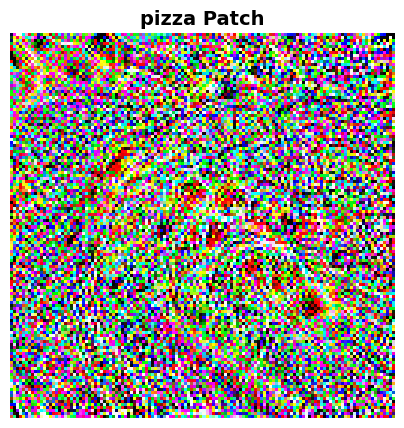

✓ Results visualization saved to: ./saved_models/pizza_training_results.png


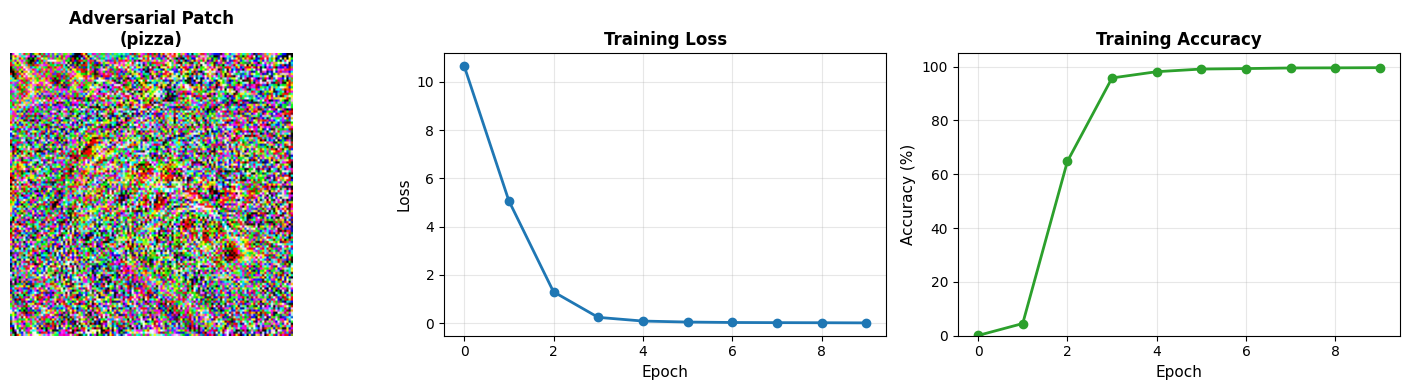

✓ Patch saved to: ./saved_models/pizza_patch_128x128.png
  Size: 2 inches at 300 DPI
  Resolution: 128x128 pixels

Testing Patch on Example Images

Image 1:
  Original: bee
  With patch: pizza (99.7%)
  Success: ✓



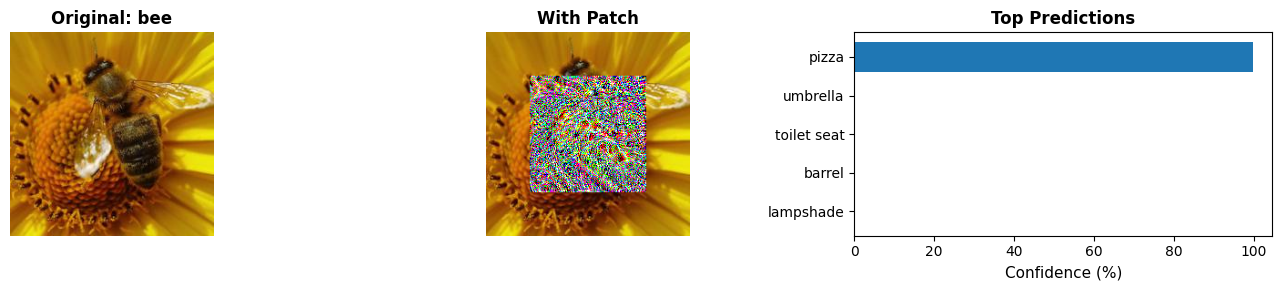

Image 2:
  Original: corkscrew
  With patch: pizza (100.0%)
  Success: ✓



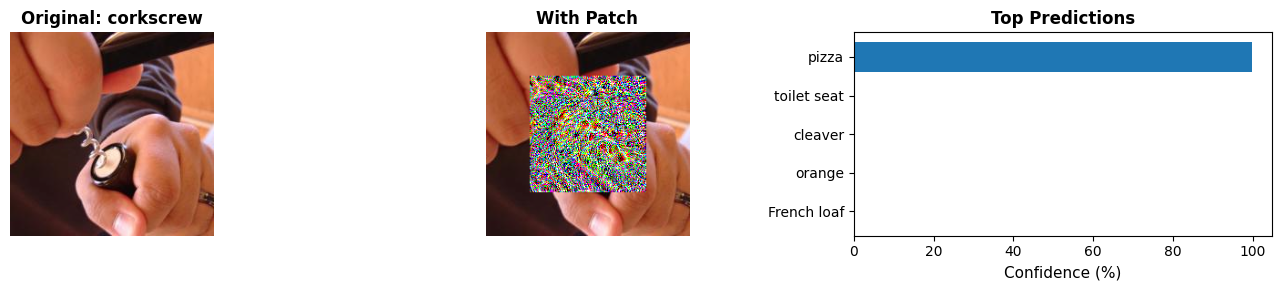

Image 3:
  Original: pineapple
  With patch: pizza (100.0%)
  Success: ✓



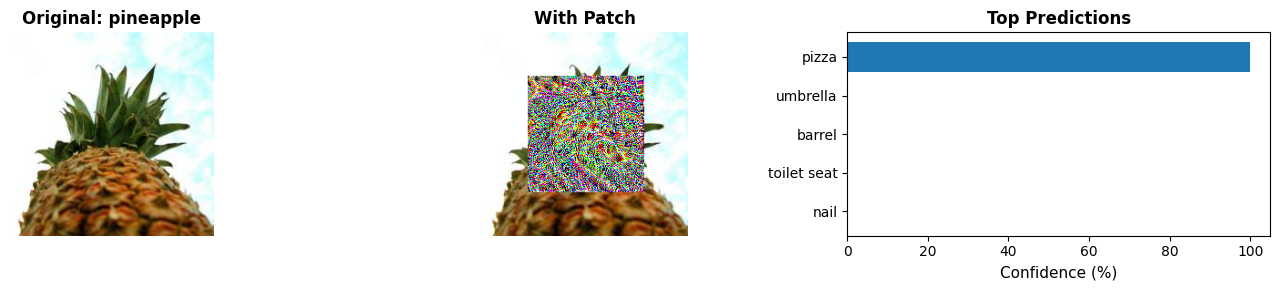

Image 4:
  Original: American coot
  With patch: pizza (99.4%)
  Success: ✓



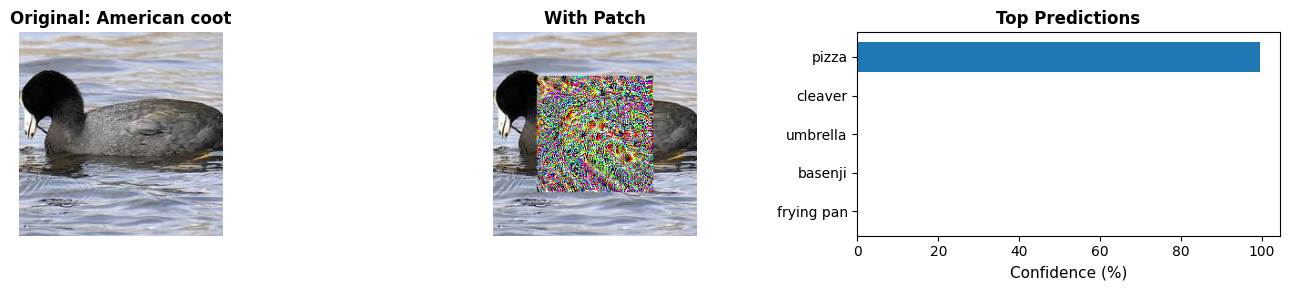

Image 5:
  Original: brambling
  With patch: pizza (99.7%)
  Success: ✓



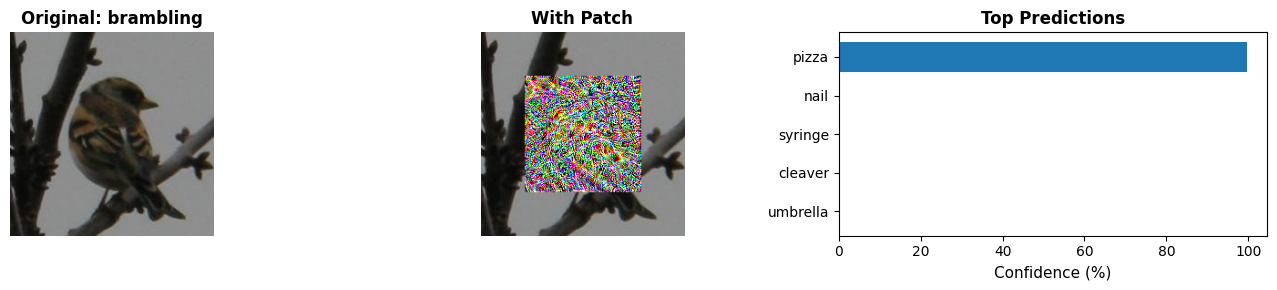

Success rate on examples: 5/5 (100%)

Patch ready.
Print the file: ./saved_models/pizza_patch_128x128.png
Test at: https://resnet34-classifier.streamlit.app/


In [ ]:
TARGET_CLASS_NAME = "pizza"
TARGET_CLASS_INDEX = get_label_index(TARGET_CLASS_NAME)

if TARGET_CLASS_INDEX is None:
    print("Class not found! Search for similar classes:")
    print(search_classes(TARGET_CLASS_NAME.split()[0])[:10])
else:
    print(f"Training patch for: {TARGET_CLASS_NAME} (index {TARGET_CLASS_INDEX})\n")

    # Train the patch
    patch, results = train_adversarial_patch(
        model=pretrained_model,
        target_class=TARGET_CLASS_INDEX,
        patch_size=128,
        num_epochs=10,
        learning_rate=1.0,
        momentum=0.9
    )

    # Visualize the patch
    print("\n" + "="*70)
    print("YOUR ADVERSARIAL PATCH")
    print("="*70 + "\n")
    visualize_patch(patch, f"{TARGET_CLASS_NAME} Patch")

    # Save everything
    save_results_visualization(patch, results, TARGET_CLASS_NAME)
    export_path = export_patch_for_printing(patch, TARGET_CLASS_NAME, size_inches=2)

    # Test on examples
    test_patch_on_images(patch, TARGET_CLASS_INDEX, num_examples=5)

    print("\n" + "="*70)
    print("Patch ready.")
    print(f"Print the file: {export_path}")
    print("Test at: https://resnet34-classifier.streamlit.app/")
    print("="*70)

In [ ]:
# Download the patch image
from google.colab import files
files.download(f"{CHECKPOINT_PATH}/{TARGET_CLASS_NAME}_patch_128x128.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>